## Montando o drive

In [5]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/Mestrado/Mestrado_CIn_2023/Topicos\ em\ IC\ 2

/content/drive/.shortcut-targets-by-id/1pgXubrQkhgRGW9noiVkc1cR9D9rwViVp/Mestrado_CIn_2023/Topicos em IC 2


In [7]:
!ls

Atividade_1_Avaliacao_de_algoritmos_Gabriel_G.ipynb  data  diabetes-dataset.zip  kaggle.json


## Carregando o dataset

https://www.kaggle.com/datasets/ehababoelnaga/diabetes-dataset

The Diabetes Dataset contains information about individuals diagnosed with diabetes, including demographic attributes, medical history, and clinical measurements. This dataset serves as a valuable resource for studying diabetes management, risk factors, and predictive modeling for disease outcomes.

In [ ]:
# Importando a chave kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabrielgaldinocin","key":"be9e1303d1a1bec5cbed783ae68cd623"}'}

In [ ]:
import json
with open('kaggle.json') as f:
  json_kaggle = json.load(f)

%env KAGGLE_USERNAME={json_kaggle['username']}
%env KAGGLE_KEY={json_kaggle['key']}

env: KAGGLE_USERNAME=gabrielgaldinocin
env: KAGGLE_KEY=be9e1303d1a1bec5cbed783ae68cd623


In [ ]:
!kaggle datasets download -d ehababoelnaga/diabetes-dataset

  0% 0.00/17.5k [00:00<?, ?B/s]
100% 17.5k/17.5k [00:00<00:00, 2.25MB/s]


In [ ]:
!unzip -q diabetes-dataset.zip -d ./data/diabetes_dataset

In [ ]:
!ls data/diabetes_dataset

Testing.csv  Training.csv


In [ ]:
import pandas as pd

# Caminho para o arquivo CSV extraído
training_file_path = 'data/diabetes_dataset/Training.csv'
test_file_path = 'data/diabetes_dataset/Testing.csv'

# Ler os arquivos CSV usando Pandas
train_df = pd.read_csv(training_file_path)
test_df = pd.read_csv(test_file_path)

# Apresentar as primeiras 5 linhas do DataFrame
print(train_df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
print(test_df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            9      120             72             22       56  20.8   
1            1       71             62              0        0  21.8   
2            8       74             70             40       49  35.3   
3            5       88             78             30        0  27.6   
4           10      115             98              0        0  24.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.733   48        0  
1                     0.416   26        0  
2                     0.705   39        0  
3                     0.258   37        0  
4                     1.022   34        0  


#### Como pode ser visto acima, o dataset possui 2 classes: Diabetico (1) e Saudável (0), cada linha representa um paciente e cada coluna um dos parâmetros abaixo:

Pregnancies: Para expressar o número de gravidezes.

Glucose: Para expressar o nível de glicose no sangue.

BloodPressure: Para expressar a medição da pressão arterial.

SkinThickness: Para expressar a espessura da pele.

Insulin: Para expressar o nível de insulina no sangue.

BMI: Para expressar o Índice de Massa Corporal.

DiabetesPedigreeFunction: Para expressar a predisposição genética para diabetes, em forma de percentual.

Age: Para expressar a idade.

Outcome: Para expressar o resultado final, onde 1 é SIM (diabetes positivo) e 0 é NÃO (diabetes negativo).

OBS: a base de treino já vem embaralhada e portanto não usarei nenhuma técnica para embaralha-la

## Importando dependências

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [20]:
# Função para realizar downsampling
def balance_dataset_by_downsampling(df, target_column):
    # Separa a classe minoritária e majoritária
    df_majority = df[df[target_column] == 0]
    df_minority = df[df[target_column] == 1]

    # Faz downsampling da classe majoritária
    df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

    # Combina a classe minoritária com a classe majoritária downsampled
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Embaralha os dados
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    return df_balanced

def load_dataset(train_path,test_path = None,downsample=False):
  # Ler os arquivos CSV usando Pandas
  train_df = pd.read_csv(train_path)
  if test_path is not None:
    test_df = pd.read_csv(test_path)

  returned_values = []
  # Separando label e dados para treino
  X_train = train_df.drop(columns=['Outcome'])
  Y_train = train_df['Outcome']
  returned_values.append(X_train)
  returned_values.append(Y_train)

  if test_path is not None:
    # Separando label e dados para teste
    X_test = test_df.drop(columns=['Outcome'])
    Y_test = test_df['Outcome']
    returned_values.append(X_test)
    returned_values.append(Y_test)

  # Balancear o dataset de treino e de teste
  if downsample:
    train_df_balanced = balance_dataset_by_downsampling(train_df, 'Outcome')
    X_train_balanced = train_df_balanced.drop(columns=['Outcome'])
    Y_train_balanced = train_df_balanced['Outcome']
    returned_values.append(X_train_balanced)
    returned_values.append(Y_train_balanced)

    if test_path is not None:
      test_df_balanced = balance_dataset_by_downsampling(test_df, 'Outcome')
      X_test_balanced = test_df_balanced.drop(columns=['Outcome'])
      Y_test_balanced = test_df_balanced['Outcome']
      returned_values.append(X_test_balanced)
      returned_values.append(Y_test_balanced)
  return tuple(returned_values)

def plot_df_class_count(Y_train,Y_test):
  train_counts = Y_train.value_counts()
  test_counts = Y_test.value_counts()

  # Plotando os resultados
  plt.figure(figsize=(8, 6))
  train_counts.plot(kind='bar')
  plt.title('Contagem de Positivos e Negativos no Dataset de treino')
  plt.xlabel('Classe')
  plt.ylabel('Contagem')
  plt.xticks(ticks=[0, 1], labels=['Negativos (0)', 'Positivos (1)'], rotation=0)
  plt.show()


  # Plotando os resultados
  plt.figure(figsize=(8, 6))
  test_counts.plot(kind='bar')
  plt.title('Contagem de Positivos e Negativos no Dataset de Teste')
  plt.xlabel('Classe')
  plt.ylabel('Contagem')
  plt.xticks(ticks=[0, 1], labels=['Negativos (0)', 'Positivos (1)'], rotation=0)
  plt.show()

def train_classifiers(classifiers_dict,X_train,Y_train):
  # Treinar cada modelo e calcular a curva ROC
  for name, classifier in classifiers_dict.items(): # Varrendo os classificados 1 a 1
    print(f"Treinando o classificador {name}")
    classifier.fit(X_train, Y_train)
  return classifiers_dict

def test_classifiers(classifiers_dict,X_test,Y_test):
  for name, classifier in classifiers_dict.items(): # Varrendo os classificados 1 a 1
    # Testando o classificador
    y_score = classifier.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # Plotar a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

## Treinamento sem balanceamento

In [21]:
# Caminho para o arquivo CSV extraído
training_file_path = 'data/diabetes_dataset/Training.csv'
test_file_path = 'data/diabetes_dataset/Testing.csv'

X_train,Y_train,X_test,Y_test = load_dataset(training_file_path,test_file_path,downsample=False)

# Verificando se a separação foi feita corretamente
print(X_train.head())
print(Y_train.head())
print(X_test.head())
print(Y_test.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  
0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            9      120             72             22       56  20.8   
1            1       71             62              0        0  21.8   
2            8       74             70             40       49  35.3   
3     

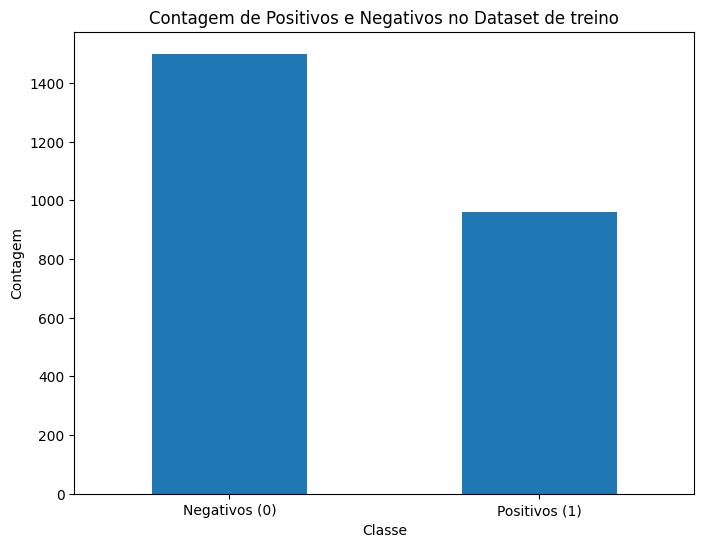

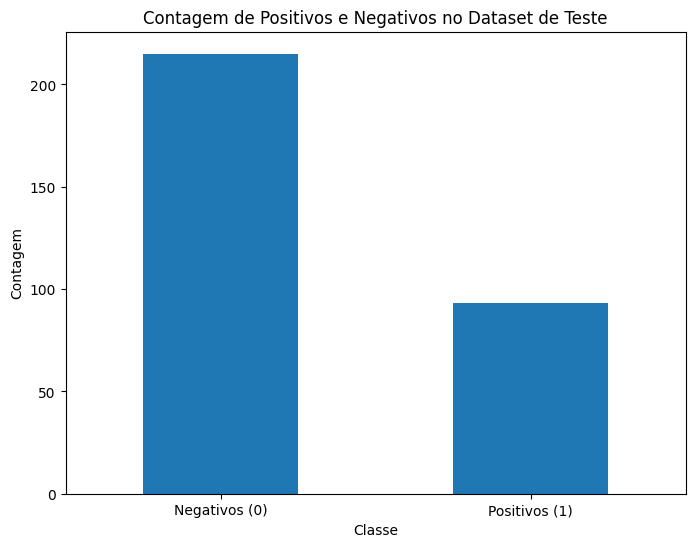

In [22]:
plot_df_class_count(Y_train,Y_test)

In [23]:
# Utilizando o standardScaler para garantir um desempenho melhor dos classificadores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Treinando o classificador Decision Tree
Treinando o classificador Bigger Decision Tree
Treinando o classificador Random Forest
Treinando o classificador Logistic Regression
Treinando o classificador Naive Bayes
Treinando o classificador kNN


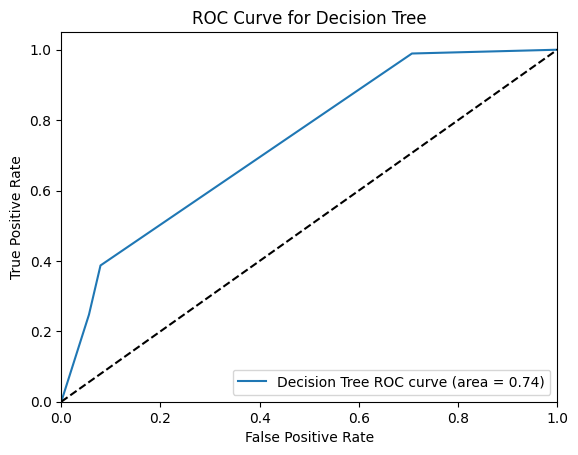

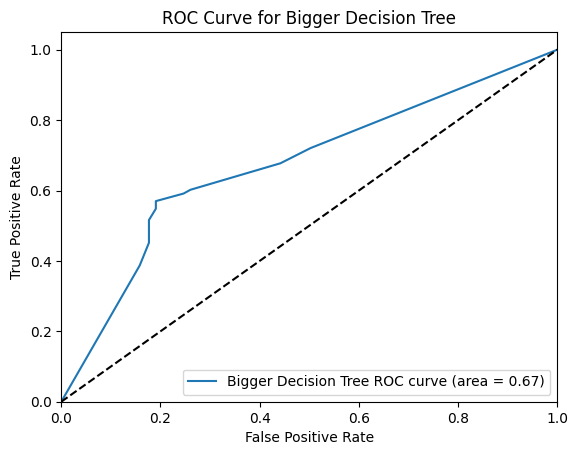

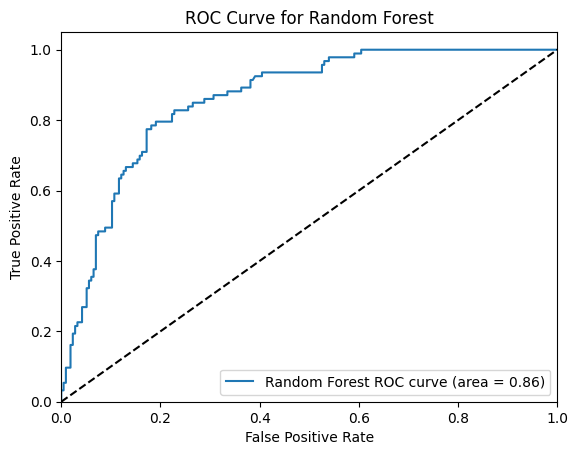

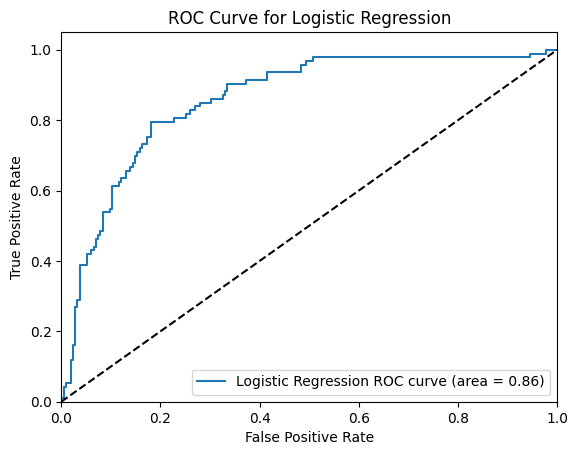

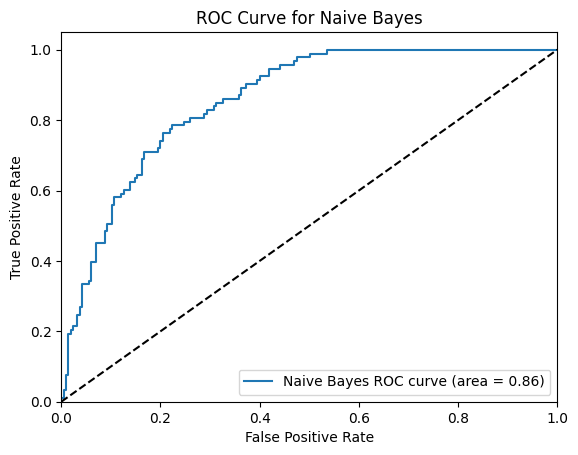

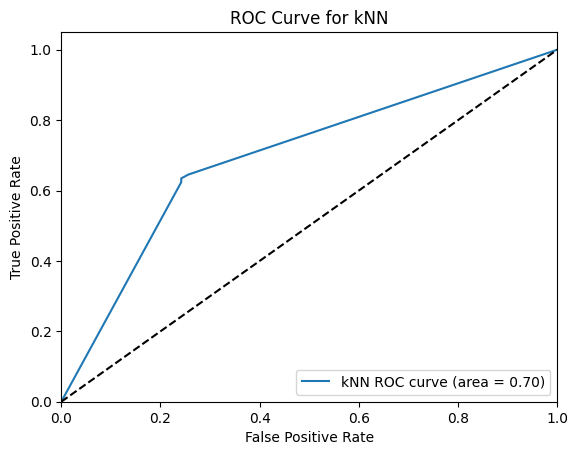

In [24]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=2),
    "Bigger Decision Tree": DecisionTreeClassifier(max_depth=8),
    "Random Forest": RandomForestClassifier(max_depth=2, n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=3)
}

classifiers = train_classifiers(classifiers,X_train,Y_train)
test_classifiers(classifiers,X_test,Y_test)


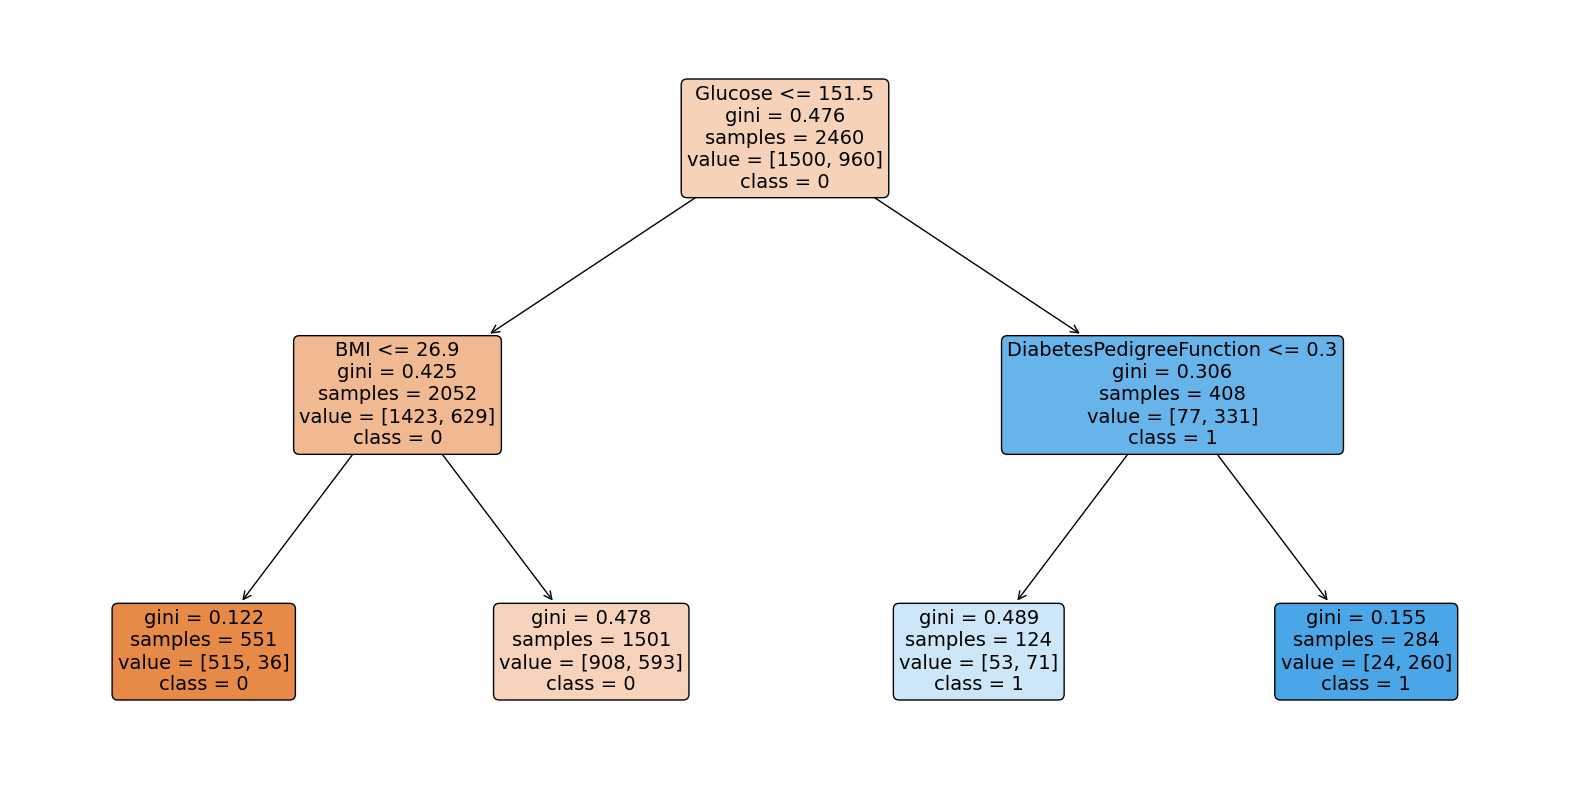

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Visualizando a árvore
plt.figure(figsize=(20,10))
a = plot_tree(classifiers["Decision Tree"],
              feature_names=X_train.columns,
              class_names=['0','1'],
              rounded=True,
              filled=True,
              fontsize=14)
plt.show()


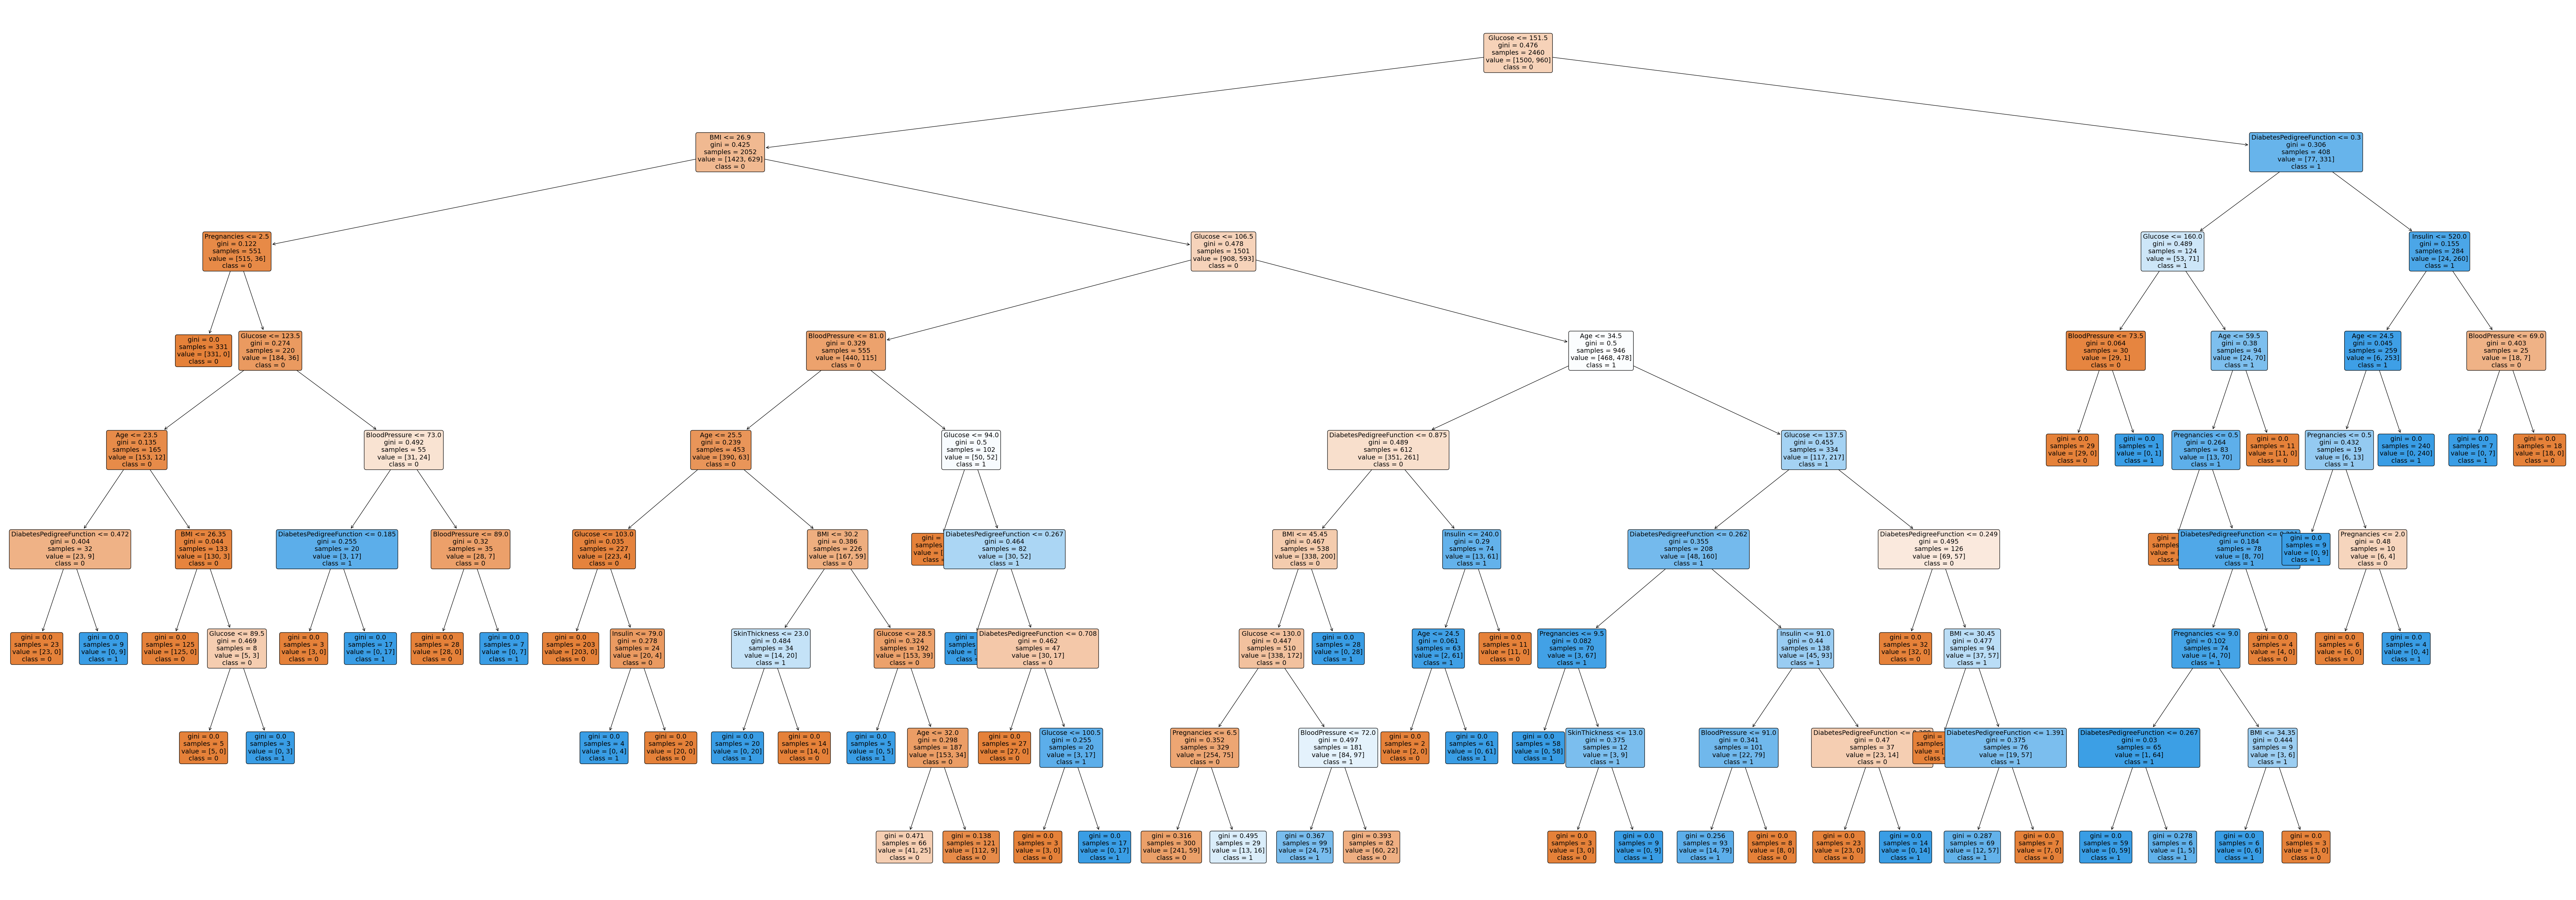

In [ ]:
# Visualizando a árvore
plt.figure(figsize=(100,35))
a = plot_tree(classifiers["Bigger Decision Tree"],
              feature_names=X_train.columns,
              class_names=['0','1'],
              rounded=True,
              filled=True,
              fontsize=14)
plt.show()

## Treinamento com balanceamento

In [34]:
# Caminho para o arquivo CSV extraído
training_file_path = 'data/diabetes_dataset/Training.csv'
test_file_path = 'data/diabetes_dataset/Testing.csv'

X_train,Y_train,X_test,Y_test,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced = load_dataset(training_file_path,test_file_path,downsample=True)

# Verificando se a separação foi feita corretamente
print(X_train_balanced.head())
print(Y_train_balanced.head())
print(X_test_balanced.head())
print(Y_test_balanced.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            0       95             85             25       36  37.4   
1            5       85             74             22        0  29.0   
2            8       85             55             20        0  24.4   
3            2       87             58             16       52  32.7   
4            4      110             66              0        0  31.9   

   DiabetesPedigreeFunction  Age  
0                     0.247   24  
1                     1.224   32  
2                     0.136   42  
3                     0.166   25  
4                     0.471   29  
0    1
1    1
2    0
3    0
4    0
Name: Outcome, dtype: int64
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      125             76              0        0  33.8   
1           10      129             62             36        0  41.2   
2            3      130             78             23       79  28.4   
3     

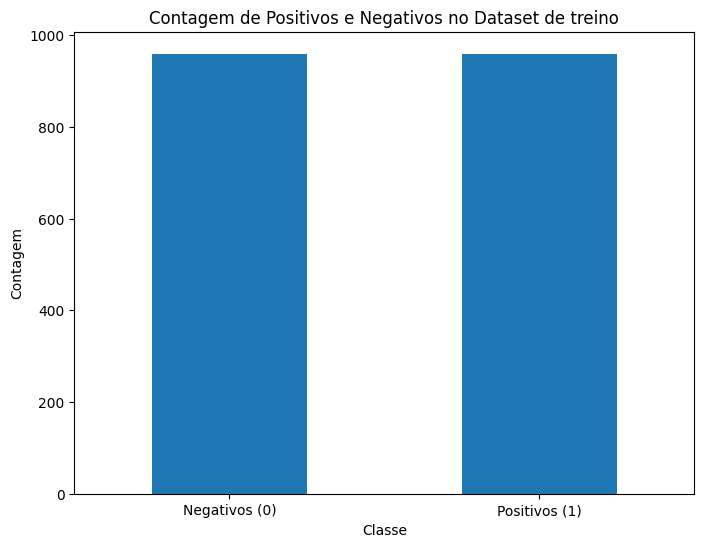

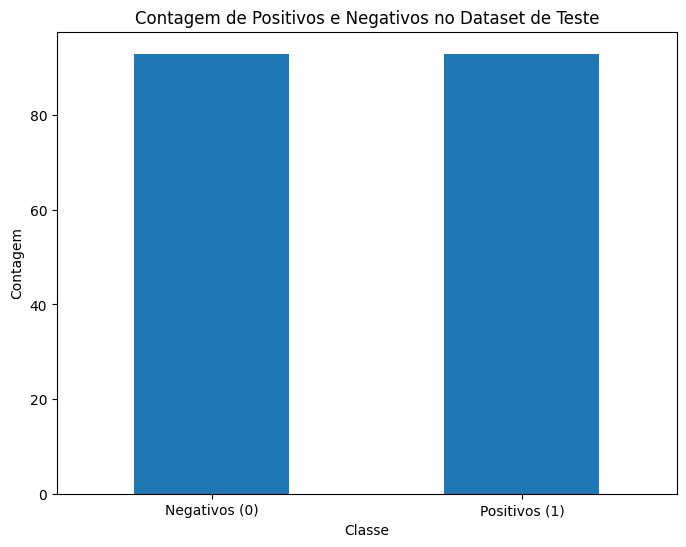

In [17]:
plot_df_class_count(Y_train_balanced,Y_test_balanced)

Treinando o classificador Decision Tree
Treinando o classificador Bigger Decision Tree
Treinando o classificador Random Forest
Treinando o classificador Logistic Regression
Treinando o classificador Naive Bayes
Treinando o classificador kNN


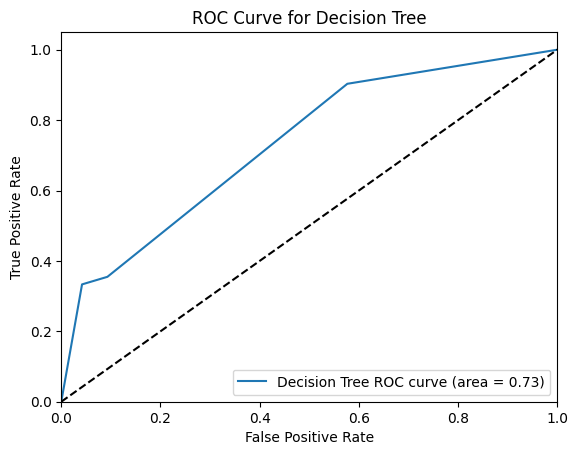

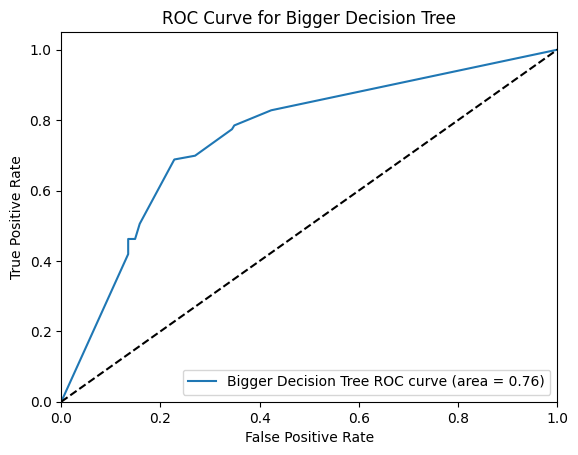

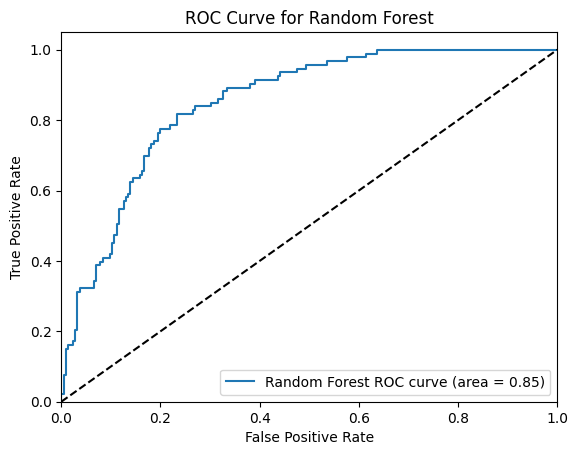

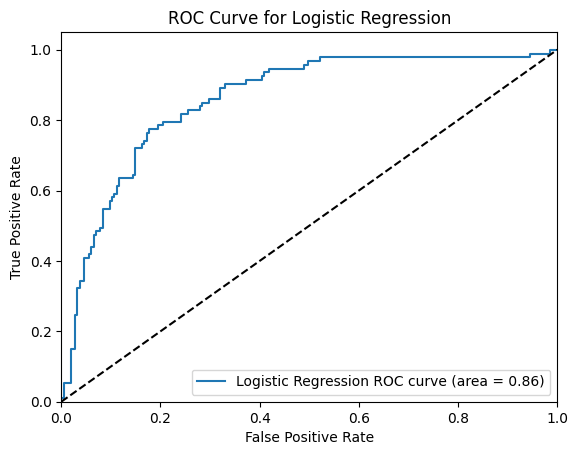

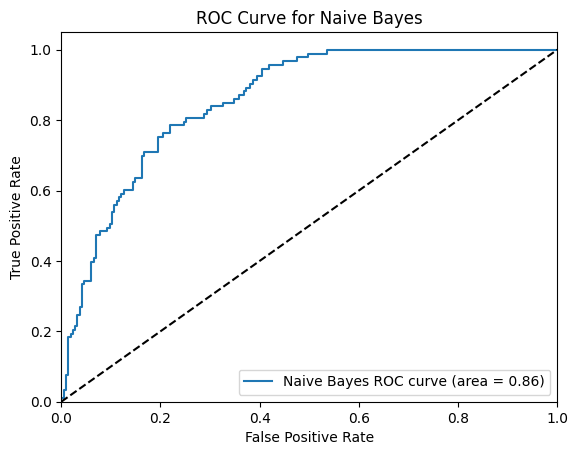

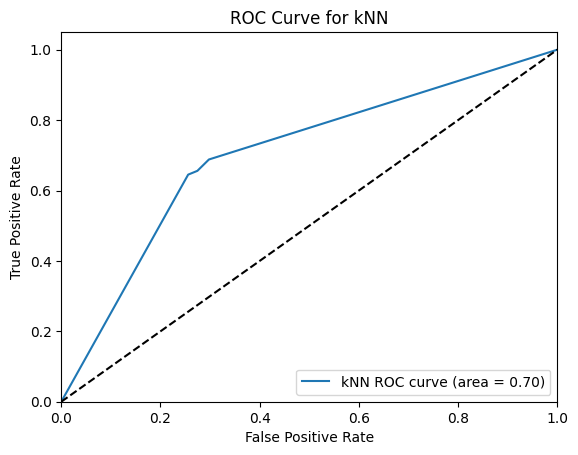

In [37]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=2),
    "Bigger Decision Tree": DecisionTreeClassifier(max_depth=8),
    "Random Forest": RandomForestClassifier(max_depth=2, n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=3)
}

X_train,Y_train,X_test,Y_test,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced = load_dataset(training_file_path,test_file_path,downsample=True)

# Utilizando o standardScaler para garantir um desempenho melhor dos classificadores
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)
X_test = scaler.transform(X_test)

classifiers = train_classifiers(classifiers,X_train_balanced,Y_train_balanced)
test_classifiers(classifiers,X_test,Y_test)

## Testando resultados em base de testes balanceada


Treinamento desbalanceado, base de teste balanceada

Treinando o classificador Decision Tree
Treinando o classificador Bigger Decision Tree
Treinando o classificador Random Forest
Treinando o classificador Logistic Regression
Treinando o classificador Naive Bayes
Treinando o classificador kNN


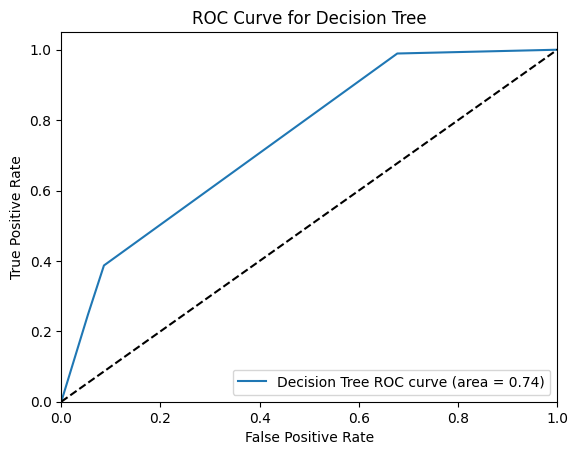

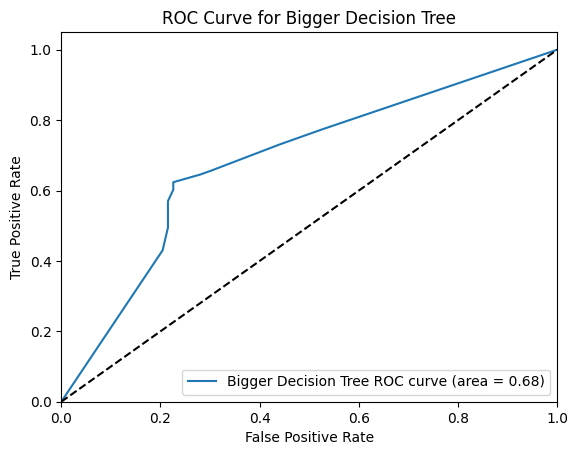

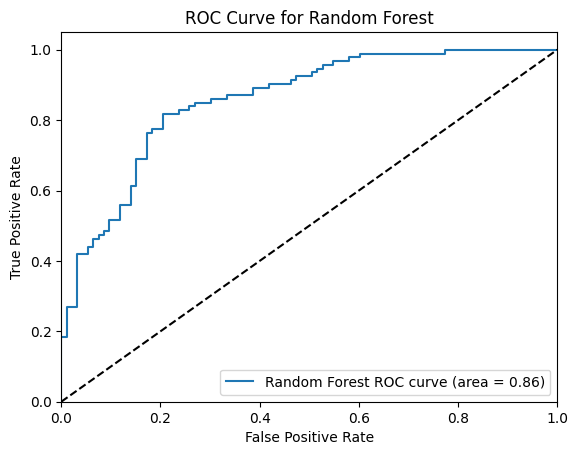

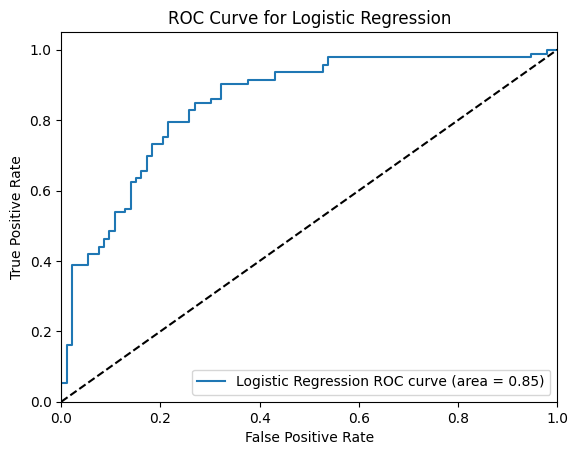

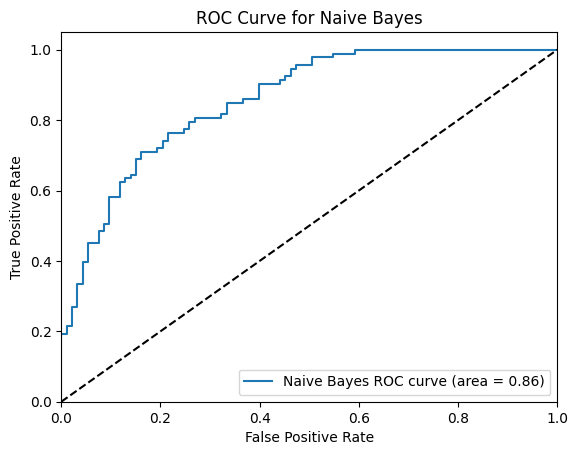

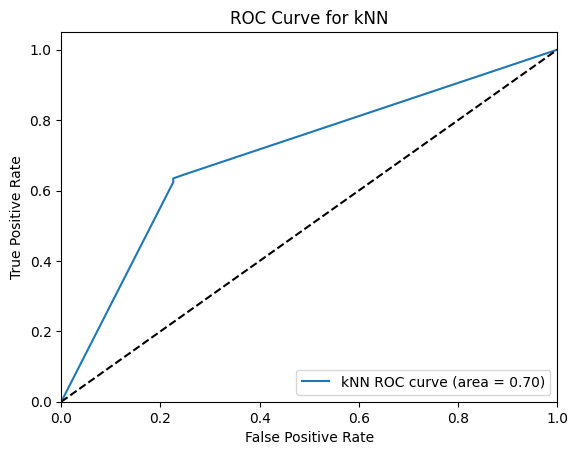

In [39]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=2),
    "Bigger Decision Tree": DecisionTreeClassifier(max_depth=8),
    "Random Forest": RandomForestClassifier(max_depth=2, n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=3)
}

X_train,Y_train,X_test,Y_test,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced = load_dataset(training_file_path,test_file_path,downsample=True)

# Utilizando o standardScaler para garantir um desempenho melhor dos classificadores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_balanced = scaler.transform(X_test_balanced)

classifiers = train_classifiers(classifiers,X_train,Y_train)
test_classifiers(classifiers,X_test_balanced,Y_test_balanced)

Treinamento e teste balanceados

Treinando o classificador Decision Tree
Treinando o classificador Bigger Decision Tree
Treinando o classificador Random Forest
Treinando o classificador Logistic Regression
Treinando o classificador Naive Bayes
Treinando o classificador kNN


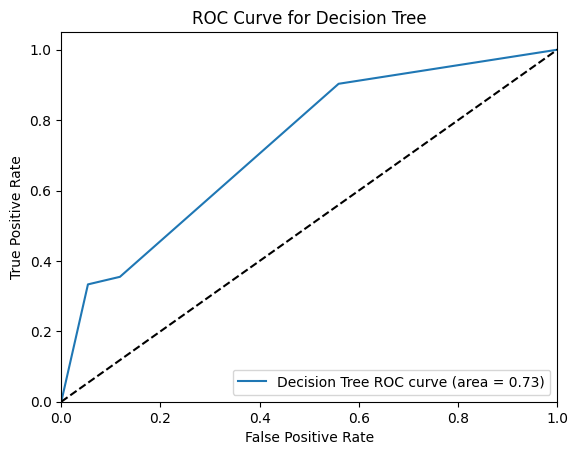

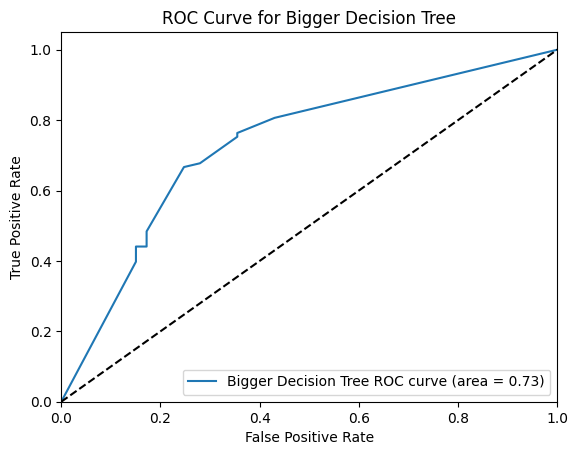

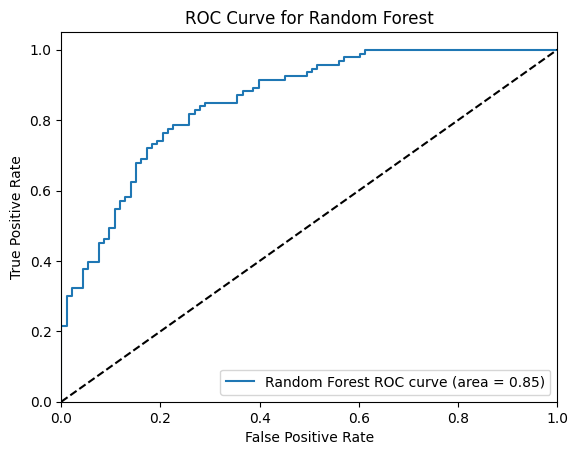

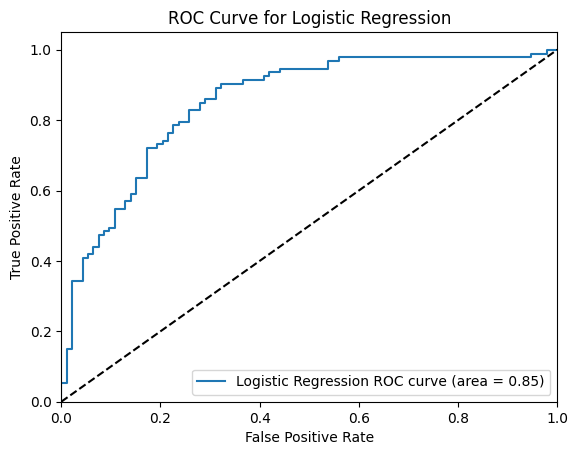

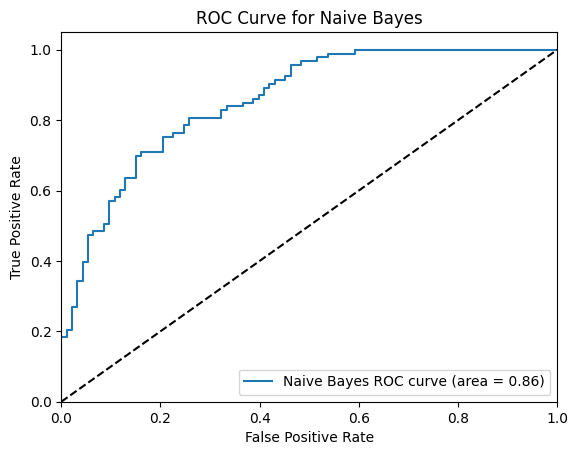

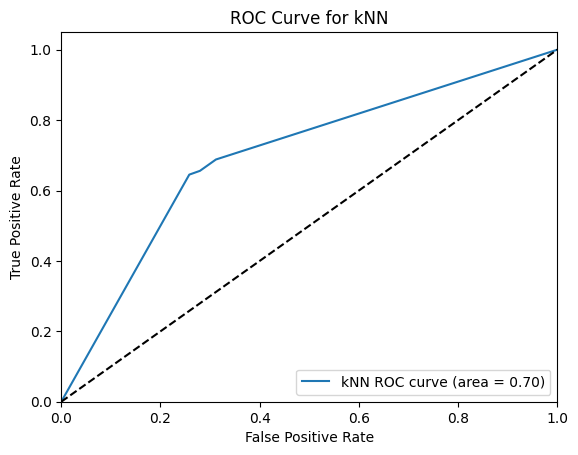

In [40]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=2),
    "Bigger Decision Tree": DecisionTreeClassifier(max_depth=8),
    "Random Forest": RandomForestClassifier(max_depth=2, n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=3)
}

X_train,Y_train,X_test,Y_test,X_train_balanced,Y_train_balanced,X_test_balanced,Y_test_balanced = load_dataset(training_file_path,test_file_path,downsample=True)

# Utilizando o standardScaler para garantir um desempenho melhor dos classificadores
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test_balanced)

classifiers = train_classifiers(classifiers,X_train_balanced,Y_train_balanced)
test_classifiers(classifiers,X_test_balanced,Y_test_balanced)